# Introduction
Recently, ResNet50 has been widely used for image classification by way of transfer learning. This time, age recognition was performed for the dataset that contains four folders including face photo images that are classified according to their age: 6 to 20, 25 to 30, 42 to 48, and 60 to 98.
# Imorting Necessary Libraries
First, necessary libraries were imported to carry out data visualization, data preparation, model training, prediction, and analysis.

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import glob

# Difining the Paths for Data

In [2]:
path = '/kaggle/input/age-recognition-dataset/Dataset'

# Visualizing the data
Next, the distribution of the age groups was confirmed in the dataset. The dataset appeared to have less number of face photos at the age between 42 and 48 than the other classes of ages. Moreover, some face images were taken for observation. Each folder appeared to contain faces of people of both genders and a wide range of races.

In [3]:
images_6_20 = glob.glob(path + "/6-20/*")
images_25_30 = glob.glob(path + "/25-30/*")
images_42_48 = glob.glob(path + "/42-48/*")
images_60_98 = glob.glob(path + "/60-98/*")

In [4]:
print(len(images_6_20))
print(len(images_25_30))
print(len(images_42_48))
print(len(images_60_98))

2514
2495
1439
2649


In [5]:
data = pd.DataFrame(np.concatenate([["6-20"] * len(images_6_20), ['25-30'] *  len(images_25_30), ['42-48'] * len(images_42_48), ['60-98'] * len(images_60_98)]), columns = ["age class"])

<AxesSubplot:xlabel='age class', ylabel='count'>

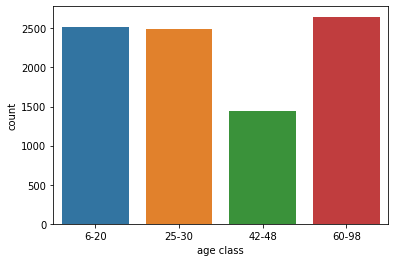

In [6]:
sns.countplot(x = 'age class', data = data)

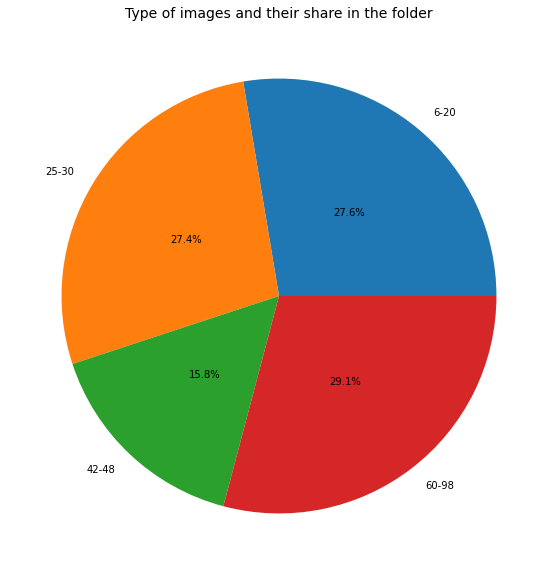

In [7]:
plt.figure(figsize = (15, 10))
plt.pie(x = np.array([len(images_6_20), len(images_25_30), len(images_42_48), len(images_60_98)]), autopct = "%.1f%%", explode = [0, 0, 0, 0], labels = ["6-20", "25-30", "42-48", "60-98"], pctdistance = 0.5)
plt.title("Type of images and their share in the folder", fontsize = 14);

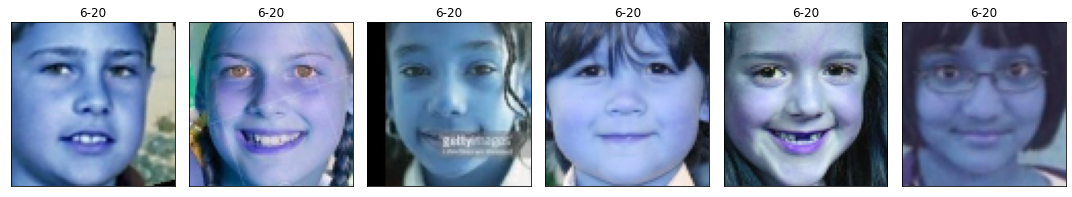

In [8]:
fig, axes = plt.subplots(nrows = 1, ncols = 6, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(images_6_20[i])
    img = cv2.resize(img, (80, 80))
    ax.imshow(img)
    ax.set_title("6-20")
fig.tight_layout()    

plt.show()

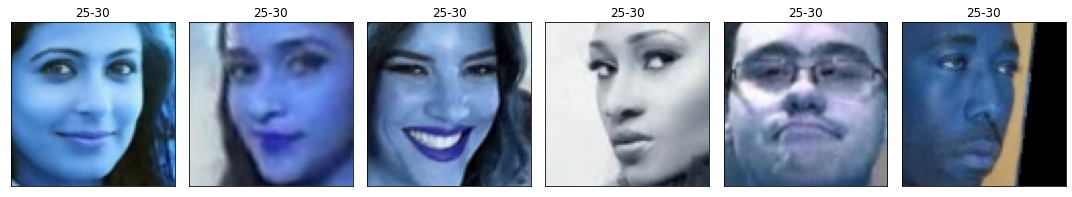

In [9]:
fig, axes = plt.subplots(nrows = 1, ncols = 6, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(images_25_30[i])
    img = cv2.resize(img, (80, 80))
    ax.imshow(img)
    ax.set_title("25-30")
fig.tight_layout()    

plt.show()

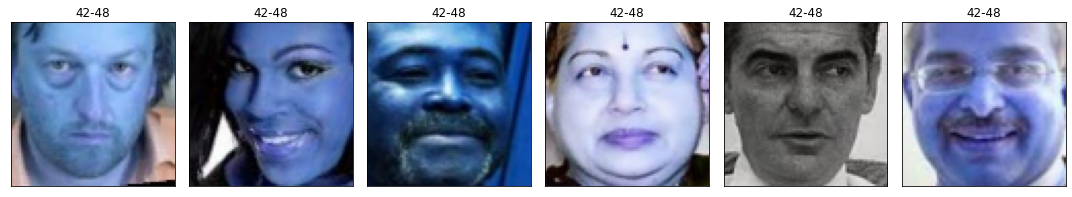

In [10]:
fig, axes = plt.subplots(nrows = 1, ncols = 6, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(images_42_48[i])
    img = cv2.resize(img, (80, 80))
    ax.imshow(img)
    ax.set_title("42-48")
fig.tight_layout()    

plt.show()

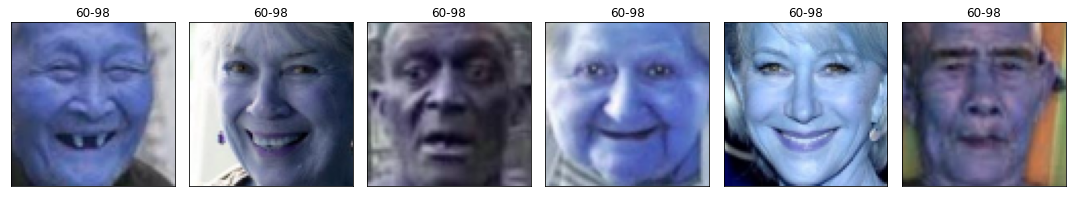

In [11]:
fig, axes = plt.subplots(nrows = 1, ncols = 6, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(images_60_98[i])
    img = cv2.resize(img, (80, 80))
    ax.imshow(img)
    ax.set_title("60-98")
fig.tight_layout()    

plt.show()

# Creating Image Data Generators
When the data generator was created, the data was not divided into training, validation, or test datasets. Thus, the batch size needed to be set as the total number of the dataset. Furthermore, the class orders had to be remade for convenience.

In [12]:
datagen = ImageDataGenerator(rescale = 1./255.,)

generator = datagen.flow_from_directory(
        path,
        target_size = (80, 80),
        class_mode = 'categorical'
)

Found 9097 images belonging to 4 classes.


In [13]:
datagen = ImageDataGenerator(rescale = 1./255.,)

full_dataloader = datagen.flow_from_directory(
    path,
    batch_size = 9097,
    target_size = (80, 80),
    class_mode = 'categorical'
)

Found 9097 images belonging to 4 classes.


In [14]:
full_dataloader.classes

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [15]:
full_dataloader.class_indices

{'25-30': 0, '42-48': 1, '6-20': 2, '60-98': 3}

In [16]:
full_dataloader.class_indices = {'25-30': 1, '42-48': 2, '6-20': 0, '60-98': 3}

In [17]:
full_dataloader.class_indices

{'25-30': 1, '42-48': 2, '6-20': 0, '60-98': 3}

# Data Processing (Splitting the Data)

The was splitted from the data loader into image and target variable. This method is simple for beginners to run. After this, the data was splitted into the train & validation data and the test data, then the former was further divided into the train data and the validation data.

In [18]:
x, t = next(iter(full_dataloader))

In [19]:
print(x.shape)
print(t.shape)

(9097, 80, 80, 3)
(9097, 4)


In [20]:
X_train_val, X_test, y_train_val, y_test = train_test_split(x, t, test_size = 0.2, random_state = 42)
X_train_val.shape, X_test.shape, y_train_val.shape, y_test.shape

((7277, 80, 80, 3), (1820, 80, 80, 3), (7277, 4), (1820, 4))

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25, random_state = 42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((5457, 80, 80, 3), (1820, 80, 80, 3), (5457, 4), (1820, 4))

# **Defining the Model**

Herem ResNet50V2 was employed as the basic model, to which a global average pooling, dense, dropout, and dense layer were added. This is a typical transfer learning of 2 dimensional convolutional neural networks. Categorical cross entropy is optimal for ordinal classification.

In [22]:
input_shape = (80, 80, 3)

base_model = ResNet50V2(
    weights = 'imagenet',
    input_shape = input_shape,
    classifier_activation = "softmax",
    include_top = False
)

for layer in base_model.layers:
    layer.trainable = True
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation = 'softmax'))

model.compile(optimizer = "adam", loss = 'categorical_crossentropy', metrics = ["accuracy"])

94674944/94668760 [==============================] - 3s 0us/step


In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 3, 3, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 23,827,588
Trainable params: 23,782,148
Non-trainable params: 45,440
_________________________________________________________________


In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", mode = "min", patience = 4)

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = 256,
    epochs = 30,
    validation_data = (X_val, y_val),
    callbacks = callback)

Epoch 1/30
22/22 [==============================] - 18s 343ms/step - loss: 1.1841 - accuracy: 0.5164 - val_loss: 32.9268 - val_accuracy: 0.2626
Epoch 2/30
22/22 [==============================] - 5s 230ms/step - loss: 0.6154 - accuracy: 0.7423 - val_loss: 16.2167 - val_accuracy: 0.3181
Epoch 3/30
22/22 [==============================] - 5s 231ms/step - loss: 0.4724 - accuracy: 0.8242 - val_loss: 13.2966 - val_accuracy: 0.4407
Epoch 4/30
22/22 [==============================] - 5s 231ms/step - loss: 0.3201 - accuracy: 0.8816 - val_loss: 2.6042 - val_accuracy: 0.6016
Epoch 5/30
22/22 [==============================] - 5s 230ms/step - loss: 0.2469 - accuracy: 0.9093 - val_loss: 1.4446 - val_accuracy: 0.6973
Epoch 6/30
22/22 [==============================] - 5s 233ms/step - loss: 0.2022 - accuracy: 0.9224 - val_loss: 1.5204 - val_accuracy: 0.7033
Epoch 7/30
22/22 [==============================] - 5s 231ms/step - loss: 0.1843 - accuracy: 0.9316 - val_loss: 2.9178 - val_accuracy: 0.5703
Ep

# Model Metrics

The accuracy and loss for the training and validation data were calculated at the same as the model training, then were visualized by graphs.

In [25]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

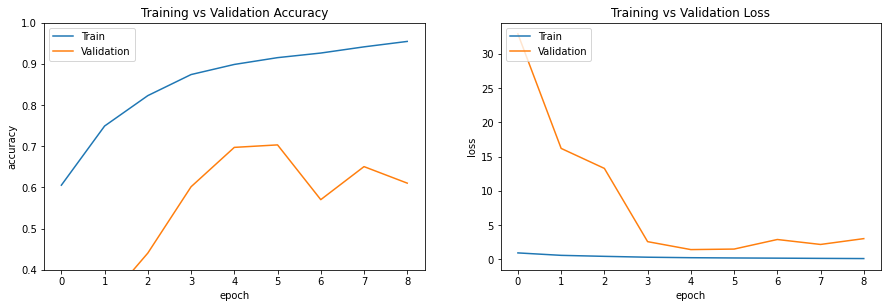

In [26]:
plt.figure(figsize = (15, 10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

# Predictions

The age category was predicted for the test data with the trained model to be compared with the actual target variable.

In [27]:
y_pred = np.argmax(model.predict(X_test, batch_size = 1), axis = 1) 

In [28]:
y_true = [np.argmax(y, axis = None, out = None) for y in y_test]

# Confusion Matrix

The comparison between predicted variable by trained model and actual variable can be well visualized by a confusion matrix. 

In [29]:
cm = confusion_matrix(y_true, y_pred)

<AxesSubplot:>

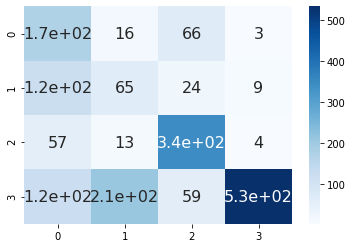

In [30]:
sns.heatmap(cm.T, annot = True, cmap = "Blues", annot_kws = {"size": 16})

Confusion Matrix


Text(69.0, 0.5, 'Predicted')

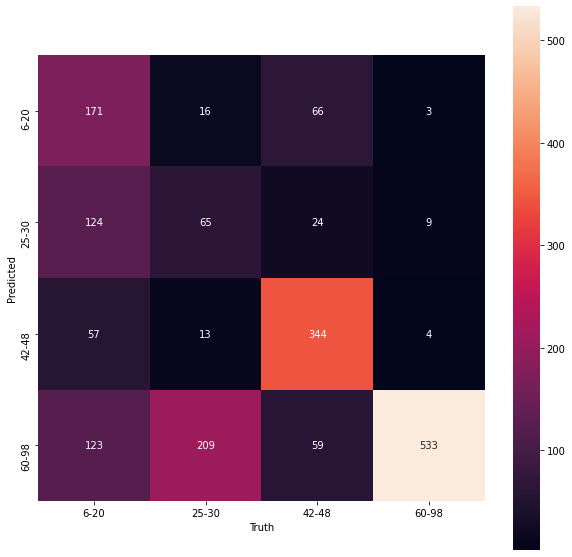

In [31]:
target_name = {'6-20': 0, '25-30': 1, '42-48': 2, '60-98': 3}
print('Confusion Matrix')
plt.figure(figsize = (10,10))
_ = sns.heatmap(cm.T, annot = True, fmt = 'd', cbar = True, square = True, xticklabels = target_name.keys(),
             yticklabels = target_name.keys())
plt.xlabel('Truth')
plt.ylabel('Predicted')

# Classification Report

A classification report provides precision, recall, and f1 score as to each classification of the test data that is carried out by the trained model. Overall, the model still had to be improved. Particularly, the model did not appear to work well to identify the age of face photos in the age group of 25 to 30.

In [32]:
print('Classification Report')
print(classification_report(y_true, y_pred, target_names = target_name.keys()))

Classification Report
              precision    recall  f1-score   support

        6-20       0.67      0.36      0.47       475
       25-30       0.29      0.21      0.25       303
       42-48       0.82      0.70      0.76       493
       60-98       0.58      0.97      0.72       549

    accuracy                           0.61      1820
   macro avg       0.59      0.56      0.55      1820
weighted avg       0.62      0.61      0.59      1820



# Analysing the Results

Finally, it is also extremely important to analyze which photos were miscategorized into another age group. For example, some face photos of 60 to 98 years old were judged as very young: ages between 2 to 20 by the trained AI (artificial intelligence) model, which is indeed impossible in the real world. Here, a list was created to retrieve these misclassified cases. Then, a data frame was created to show which photos were actually grouped as 3 (ages between 60 to 98) but judged as group 0 (ages between 6 to 20). The number of these photos was around 20 to 30, and 5 examples were displayed. These people were clearly old.

In [33]:
confusion = []

for i, j in zip(y_true, y_pred):
  if i == 3 and j == 0:
    confusion.append('Yes')
  else:
    confusion.append('No')

In [34]:
confusion

['No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'Yes',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No',
 'No'

In [35]:
confusion_table = pd.DataFrame(data = confusion, columns = ["Looks Young"])
confusion_table

,Looks Young
0,No
1,No
2,No
3,No
4,No
...,...
1815,No
1816,No
1817,No
1818,No


In [36]:
confusion_table = pd.DataFrame({'Predicton':y_pred,
                                'Truth': y_true,
                                'Looks Young': confusion})
confusion_table

,Predicton,Truth,Looks Young
0,1,2,No
1,3,3,No
2,3,0,No
3,3,0,No
4,2,2,No
...,...,...,...
1815,3,0,No
1816,2,2,No
1817,3,3,No
1818,3,1,No


In [37]:
confusion_table['Looks Young'] == 'Yes'

0       False
1       False
2       False
3       False
4       False
        ...  
1815    False
1816    False
1817    False
1818    False
1819    False
Name: Looks Young, Length: 1820, dtype: bool

In [38]:
Looks_Young = confusion_table[confusion_table['Looks Young'] == 'Yes']
Looks_Young

,Predicton,Truth,Looks Young
120,0,3,Yes
1211,0,3,Yes
1805,0,3,Yes


In [39]:
Looks_Young.index

Int64Index([120, 1211, 1805], dtype='int64')

In [40]:
'''
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
# Insert five numbers shown above.
for i, ax in zip([,  ,  ,  ,  ], axes.flat):
    img = cv2.imread(images_60_98[i])
    img = cv2.resize(img, (80, 80))
    ax.imshow(img)
    ax.set_title("Looks Young")
fig.tight_layout()    

plt.show()
'''

'\nfig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (15, 10), subplot_kw = {\'xticks\':[], \'yticks\':[]})\n# Insert five numbers shown above.\nfor i, ax in zip([,  ,  ,  ,  ], axes.flat):\n    img = cv2.imread(images_60_98[i])\n    img = cv2.resize(img, (80, 80))\n    ax.imshow(img)\n    ax.set_title("Looks Young")\nfig.tight_layout()    \n\nplt.show()\n'

# Conclusion

Unfortunately, this model did not appear to be so useful to recognize the age of their faces. Moreover, it is not known how the trained model recognized their age. Ideally speaking, the process should be clarified in which the AI model judges the age of human faces. Further improvement is expected to produce a more practical AI model.